In [59]:
import pickle
import IPython.display as ipd
# feature extractoring and preprocessing data
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from pathlib import Path
import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import signal
import scipy
import noisereduce as nr
#Reports
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import os
import pydub

In [2]:
audio_path = Path('/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M')

In [27]:
e_file = '/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/amecro/XC264942.mp3'
ipd.display(ipd.Audio(e_file))
y, sr = librosa.load(e_file)
reduced_noise = nr.reduce_noise(y=y, sr=sr, thresh_n_mult_nonstationary=2,stationary=False)

In [28]:
ipd.Audio(data=reduced_noise, rate=sr)

In [22]:
from scipy import signal
def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf

In [29]:
ipd.Audio(data=f_high(reduced_noise, sr), rate=sr)

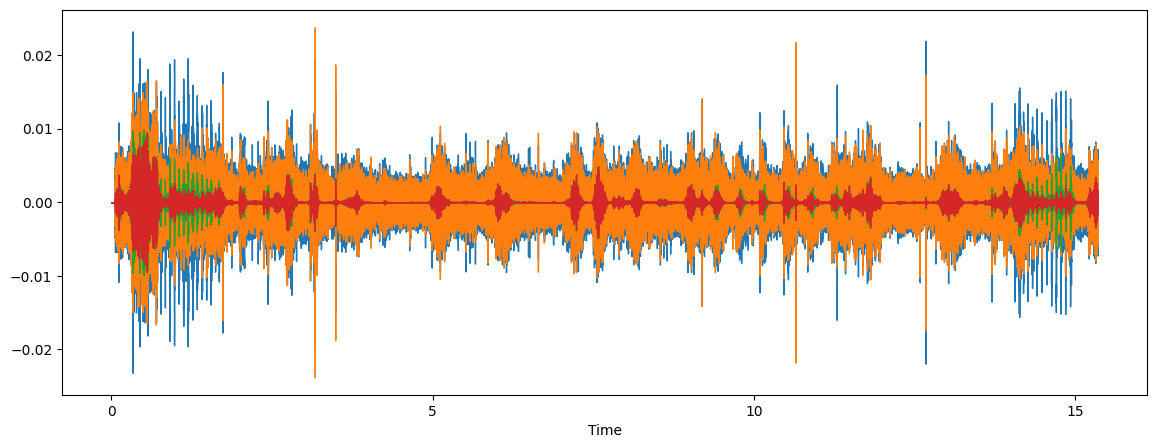

In [56]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
librosa.display.waveshow(f_high(y, sr), sr=sr)
librosa.display.waveshow(reduced_noise, sr=sr)
librosa.display.waveshow(f_high(reduced_noise, sr), sr=sr)

In [3]:
sr = 32000

In [4]:
df = pd.read_csv('./train_extended.csv')
# Selecting high-rated sound only
dff = df[df['rating'] > 3.0]
# Selecting shorter files only, less data to process
dff = dff[df['duration'] < 20]
print(len(dff))

3954


In [5]:
# Selecting birds with more than 10 examples left
dfc = dff.groupby('ebird_code')['ebird_code'].count()
dff = dff[~dff['ebird_code'].isin(dfc[dfc.values < 20].index)]
print(len(dff))

2967


In [6]:
sound_categories = dff['ebird_code'].unique()

In [7]:
sound_categories

array(['amecro', 'amerob', 'barswa', 'bewwre', 'blujay', 'bnhcow',
       'cangoo', 'carwre', 'caster1', 'chispa', 'comrav', 'comred',
       'comter', 'comyel', 'daejun', 'easmea', 'eastow', 'eucdov',
       'eursta', 'gadwal', 'gnwtea', 'greegr', 'grtgra', 'grycat',
       'horlar', 'houfin', 'houspa', 'houwre', 'mallar3', 'marwre',
       'norcar', 'norfli', 'normoc', 'redcro', 'rewbla', 'savspa',
       'sonspa', 'spotow', 'swathr', 'tuftit', 'warvir', 'wesmea',
       'whtspa'], dtype=object)

In [8]:
mfcc_df = pd.DataFrame([], columns = ['ebird_code', 'mfcc_mean'])

In [10]:
from tqdm.notebook import tqdm

In [58]:
header = 'filename label chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' de_chroma_stft de_rmse de_spectral_centroid de_spectral_bandwidth de_rolloff de_zero_crossing_rate'
for i in range(1, 21):
    header += f' de_mfcc{i}'
header = header.split()
file = open('data.csv', 'w', newline='')
writer = csv.writer(file)
writer.writerow(header)
file.close()

In [30]:
def reduce_noise(y, sr):
    reduced_noise = nr.reduce_noise(y=y, sr=sr, thresh_n_mult_nonstationary=2,stationary=False)
    return f_high(reduced_noise, sr)

In [57]:
def feature_extractor(sound_path, category_name, file_name):
    y, y_sr = librosa.load(sound_path, mono=True)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=y_sr)
    rmse = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{file_name} {category_name} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
    for e in mfcc:
        to_append += f' {np.mean(e)}'
    y_denoise = reduce_noise(y, y_sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_denoise, sr=y_sr)
    rmse = librosa.feature.rms(y=y_denoise)
    spec_cent = librosa.feature.spectral_centroid(y=y_denoise, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_denoise, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y_denoise, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y_denoise)
    mfcc = librosa.feature.mfcc(y=y_denoise, sr=sr)
    to_append += f' {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
    for e in mfcc:
        to_append += f' {np.mean(e)}'
    # print(to_append)
    file = open('data.csv', 'a', newline='')
    writer = csv.writer(file)
    writer.writerow(to_append.split())
    file.close()

In [61]:
category_progress = tqdm(sound_categories)
for category_name in category_progress:
    category_progress.desc = category_name
    #Walk through the dataframe filename values
    l_files = dff[dff['ebird_code'] == category_name]['filename'].values
    tqdm.write("Bird: "+category_name+"  files: "+str(len(l_files)))
    for file_name in tqdm(l_files, desc='Files'):
        try:
            sound_path = audio_path/category_name/file_name
            feature_extractor(sound_path, category_name, file_name)
        except Exception as e:
            print(e)
            pass

amecro:   0%|          | 0/43 [00:00<?, ?it/s]

Bird: amecro  files: 33


amerob:   2%|▏         | 1/43 [00:36<25:37, 36.61s/it]

Bird: amerob  files: 55


barswa:   5%|▍         | 2/43 [01:41<36:30, 53.42s/it]

Bird: barswa  files: 157


bewwre:   7%|▋         | 3/43 [05:02<1:20:31, 120.78s/it]

Bird: bewwre  files: 75


blujay:   9%|▉         | 4/43 [06:40<1:12:43, 111.87s/it]

Bird: blujay  files: 62


bnhcow:  12%|█▏        | 5/43 [08:04<1:04:23, 101.67s/it]

Bird: bnhcow  files: 29


cangoo:  14%|█▍        | 6/43 [08:37<48:14, 78.23s/it]   

Bird: cangoo  files: 41


carwre:  16%|█▋        | 7/43 [09:38<43:38, 72.72s/it]

Bird: carwre  files: 80


caster1:  19%|█▊        | 8/43 [11:35<50:35, 86.73s/it]

Bird: caster1  files: 20


chispa:  21%|██        | 9/43 [12:04<38:53, 68.64s/it] 

Bird: chispa  files: 29


comrav:  23%|██▎       | 10/43 [12:48<33:39, 61.19s/it]

Bird: comrav  files: 217


comred:  26%|██▌       | 11/43 [17:39<1:10:07, 131.48s/it]

Bird: comred  files: 40


comter:  28%|██▊       | 12/43 [18:30<55:16, 107.00s/it]  

Bird: comter  files: 83


comyel:  30%|███       | 13/43 [20:18<53:41, 107.39s/it]

Bird: comyel  files: 53


daejun:  33%|███▎      | 14/43 [21:29<46:30, 96.22s/it] 

Bird: daejun  files: 39


easmea:  35%|███▍      | 15/43 [22:27<39:29, 84.64s/it]

Bird: easmea  files: 25


eastow:  37%|███▋      | 16/43 [23:08<32:13, 71.62s/it]

Bird: eastow  files: 27


eucdov:  40%|███▉      | 17/43 [23:44<26:25, 61.00s/it]

Bird: eucdov  files: 107
